__Нейросетевая языковая модель на основе LSTM__ 

Евгений Борисов <esborisov@sevsu.ru>

# загружаем тексты

In [1]:
import gzip
import requests
from bs4 import BeautifulSoup

In [2]:
# url='http://lib.ru/NEWPROZA/LOBAS/taxisty.txt'
# text = BeautifulSoup(requests.get(url).text).get_text()
# with gzip.open('taxisty.txt.gz','wt') as f: f.write(text)

# # with gzip.open('taxisty.txt.gz','rt') as f: text = f.read()

# text = text[1030:-7261].strip() # выкидываем заголовок и хвост страницы 
# print(f'символов:{len(text)}\n---------------\n'%())
# print(text[:343])

In [3]:
url='http://az.lib.ru/d/dostoewskij_f_m/text_0080.shtml'
text = BeautifulSoup(requests.get(url).text).get_text()
with gzip.open('dostoewskij.txt.gz','wt') as f: f.write(text)

# with gzip.open('dostoewskij.txt.gz','rt') as f: text = f.read()

text = text[2876:-664184].strip() # выкидываем заголовок и хвост страницы 
print(f'символов:{len(text)}\n---------------\n'%())
print(text[:355])

символов:1279540
---------------

Приступая к описанию недавних и столь странных событий, происшедших в нашем, доселе ничем не отличавшемся городе, я принужден, по неумению моему, начать несколько издалека, а именно некоторыми биографическими подробностями о талантливом и многочтимом Степане Трофимовиче Верховенском. Пусть эти подробности послужат лишь введением к предлагаемой хронике, 


---

In [4]:
from tqdm.auto import tqdm
from itertools import chain
import numpy as np

In [5]:
from nltk import __version__ as nltk_version
print('nltk version:',nltk_version)

from nltk.tokenize import sent_tokenize as nltk_sentence_split
from nltk.tokenize import word_tokenize as nltk_tokenize_word
from nltk.util import ngrams

nltk version: 3.8.1


In [6]:
# !pip install torch

In [7]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F

In [8]:
# !pip install torchtext

In [9]:
# import torchtext
# from torchtext.data import get_tokenizer

In [10]:
class ContextDataset(Dataset):
    
    def __init__(self, text, context_len=5 ):
        assert context_len>1
        assert len(text)>1
        
        self._tokens = ['<UNK>','<EOS>',] # служебные токены "неизвестное слово", "конец последовательности"
        
        self._context_len = context_len # количество слов контекста слева 
        # выполняем токенизацию текста 
        self._sentences = [ 
            nltk_tokenize_word(s,language='russian') # разбиваем предложения на слова
            for s in tqdm(nltk_sentence_split(text,language='russian')) # режем текст на отдельные предложения
        ]
        # строим словарь
        self._vocabulary = self._build_vocabulary(self._sentences)
        # выкидываем короткие предложения, добавляем служебный токен "конец последовательности"
        self._sentences = [ s + [ '<EOS>' ] for s in self._sentences if len(s)> self._context_len ]
        # собираем n-граммы длинны context_len+1
        self._data = self._encode_ngrams( self._build_ngrams(self._sentences) )
        
    def _build_vocabulary(self,sentences):        
        # собираем токены (слова) из текста, добавляем служебные
        text_tokens = self._tokens + sorted( set(chain(*sentences))-set(self._tokens) ) 
        return { w:n for n,w in enumerate(text_tokens) } # строим словарь
    
    def _build_ngrams(self, sentences):
        return [ # нарезаем последовательности токенов на n-граммы
            ng for s in tqdm(sentences)  
               for ng in ngrams( s, self._context_len+1 ) 
        ]
    
    def _encode_ngrams(self,ngrams): # заменяем токены в n-граммах на номера в словаре
        return torch.tensor([ self.encode(ng) for ng in tqdm(ngrams) ], dtype=torch.long ) 
    
    def encode(self,s): return [ # заменить в последовательности все токены на их номера в словаре
            self._vocabulary[w] if (w in self._vocabulary) else  self._vocabulary['<UNK>']
            for w in s 
        ]
    
    def __getitem__(self, idx): # выдать элемент датасета номер idx
        return (
            self._data[idx,:-1], # последовательность кодов контеста
            self._data[idx,-1] # выход модели - номер слова 
            # self._num2vec( self._data[idx,-1]) 
        )
    
    #def _num2vec(self,x): # заменяем номер слова на вектор [0,1] длинны в размер словаря
    #    return F.one_hot( x, num_classes=len(self._vocabulary)).to( torch.float32 ) 

    # размер датасета
    def __len__(self): return len(self._data)
    
    @property
    def vocabulary(self): return self._vocabulary
    
    @property
    def sentences(self): return self._sentences

    @property
    def context_len(self): return self._context_len

In [11]:
ds = ContextDataset(text=text,context_len=5)

  0%|          | 0/14424 [00:00<?, ?it/s]

  0%|          | 0/12230 [00:00<?, ?it/s]

  0%|          | 0/196359 [00:00<?, ?it/s]

In [12]:
display(len(ds)) # размер датасета
display(len(ds.sentences)) # количество предложений 
display(len(ds.vocabulary)) # размер словаря
display(max(ds.vocabulary.values())) # максимальное значение индекса в словаре

196359

12230

32446

32445

In [13]:
assert len(ds.vocabulary)== max(ds.vocabulary.values())+1

In [14]:
display(ds[:2])

(tensor([[ 3213, 12223, 17783, 15767, 11501],
         [12223, 17783, 15767, 11501, 28249]]),
 tensor([28249, 28331]))

# модель

In [15]:
import torch.nn as nn
import torch.nn.functional as F

In [16]:
class ModelRNN(nn.Module):
    
    def __init__(self, vocabulary, embedding_len=128, hidden_dim=512,):
        super().__init__()
        self._vocabulary = vocabulary
        self._embeddings = nn.Embedding( len(vocabulary), embedding_len )
        self._gru = nn.GRU( input_size=embedding_len, hidden_size=hidden_dim, batch_first=True, num_layers=1, ) 
        self._linear = nn.Linear( hidden_dim, len(vocabulary) )

    def forward(self,x):
        o = self._embeddings(x)
        o, (h,c) = self._gru(o) # обрабатываем входную последовательность
        o = o[:,-1]
         
        o = self._linear(o) # считаем выход сети
        o = F.log_softmax(o,dim=-1)
        return o
    
    def predict(self,x):
        return torch.argmax(self.forward(x), dim=-1 ) #, keepdims=True)
    
    @property
    def vocabulary(self): return self._vocabulary

In [17]:
# x,t = ds[:2]
# ModelRNN(vocabulary=ds.vocabulary).predict(x)

# обучаем модель

In [18]:
# проверяем GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
display( device )
display( torch.cuda.get_device_name() )

device(type='cuda', index=0)

'Tesla P40'

In [19]:
model = ModelRNN(vocabulary=ds.vocabulary,).to(device)

In [20]:
# ф-ция потери
# criterion =  nn.BCELoss()
criterion = nn.NLLLoss()

# метод оптимизации
optimizer = torch.optim.Adam( model.parameters(), lr=1e-3) 

In [21]:
from torch.utils.data import DataLoader

In [22]:
loss_history = [] # значения ф-ции потери

In [23]:
%%time

n_epoch = 9 # количество эпох обучения

for i in tqdm(range(n_epoch)): 
    loss_batch = []
    # получаем батч учебных примеров
    for x,t in DataLoader( ds, batch_size=128, shuffle=True): 
        o = model.forward(x.to(device)) # считаем выход модели
        loss = criterion( o, t.to(device) ) # вычисляем значение ф-ции потери
        loss_batch.append( loss.item() ) # дополняем историю изменения значений ф-ции потери на батче
        optimizer.zero_grad() # очищаем предыдущее значение градиента
        loss.backward()  # вычисляем текущее значение градиента ф-ции потери
        optimizer.step() # корректируем параметры модели
    
    loss_history.append( np.mean(loss_batch) ) # дополняем общую историю изменения значений ф-ции потери

  0%|          | 0/9 [00:00<?, ?it/s]

CPU times: user 2min 14s, sys: 402 ms, total: 2min 14s
Wall time: 2min 14s


Text(0.5, 1.0, 'min loss: 0.34094')

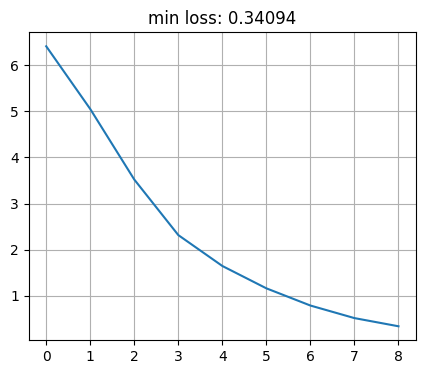

In [24]:
from matplotlib import pyplot as plt

fig,ax = plt.subplots(figsize=(5,4))
ax.plot(loss_history)
ax.grid()
ax.set_title(f'min loss: {min(loss_history):.5f}')

# тестируем

In [26]:
from random import sample
from nltk.util import ngrams 

prompts = [
        ' '.join(ng) 
        for s in sample( ds.sentences,10 ) 
        if len(s)>ds.context_len*2
        for ng in list(ngrams(s[:ds.context_len],ds.context_len))  
    ]

display( prompts )

['Можете ли вы поверить ,',
 'Брачная жизнь развратит меня ,',
 'Софья Матвеевна вдруг запнулась и',
 '- Вас первого человека встречаю',
 'Я хочу , чтобы Дарья',
 'Но он тогда самоициозничал и',
 'Варвара Петровна похвалила и поблагодарила',
 'Степан Трофимович покоробился , но']

In [27]:
class LangModelRNN: # генератор текста 
    
    def __init__(self,model):
        self._model = model # языковая модель, предсказывает слово по контексту
        self._vocabulary = model.vocabulary # словарь языковой модели
        self._vocabulary_inv = { v:k for k,v in self._vocabulary.items() }
    
    def predict(self,prompt,seq_limit=10):
        x = self._encode(prompt) # начальная последовательность токенов
        codes = self._generate(x,seq_limit)
        return self._decode(codes) # конвертируем коды токенов в строку

    def _generate(self,x,seq_limit):
        device = next(self._model.parameters()).device 
        codes = [] # коды токенов сгенерированных моделью

        for _ in range(seq_limit):
            with torch.set_grad_enabled(False): # генерируем следующий токен
                p = self._model.predict(x.to(device)).cpu() #.item()
            codes.append(p.item()) # сохраняем результат
            # сдвигаем входную последовательность токенов
            x = torch.concat([ x[:,1:], p.reshape(-1,1) ], dim=1 ) 
            # если получили токен "конец последовательности", то завершаем цикл
            if p.item()==self._vocabulary['<EOS>']: break 
                
        return codes
    
    def _encode(self,s): # кодируем строку
        s = nltk_tokenize_word(s,language='russian')
        s = [ self._vocabulary[w] for w in s if (w in self._vocabulary) ]
        return torch.tensor([s], dtype=torch.long )
    
    def _decode(self,s): # конвертируем коды токенов в строку
        return ' '.join([ 
            self._vocabulary_inv[c] 
            for c in s if (c in self._vocabulary_inv) 
        ])

In [28]:
generator = LangModelRNN(model)
for prompt in prompts:
    t = generator.predict(prompt,seq_limit=40)
    print(prompt,'-->', t,'\n')

Можете ли вы поверить , --> что я сделал . <EOS> 

Брачная жизнь развратит меня , --> отнимет энергию , мужество в служении делу , пойдут дети , еще , пожалуй , не мои в ней свете . <EOS> 

Софья Матвеевна вдруг запнулась и --> совсем стала в тупик . <EOS> 

- Вас первого человека встречаю --> , лично знающего ; и если только на этом деле под пресс-папье ... что я подумал тогда однажды в Петербурге `` не мог '' . <EOS> 

Я хочу , чтобы Дарья --> Павловна сама объявила мне из своих уст и пред лицом неба , или по крайней мере пред вами , или , как пред вами в качестве уполномоченного и бог в лицо его никто не могли на ее . <EOS> 

Но он тогда самоициозничал и --> с особенною поспешностью распорядился уверить себя раз навсегда , что карьера его разбита на всю его жизнь `` вихрем обстоятельств '' . <EOS> 

Варвара Петровна похвалила и поблагодарила --> его за прекрасную мысль , а Даша была в восторге . <EOS> 

Степан Трофимович покоробился , но --> смолчал , Даша вспыхнула ; тем и кончилас